## Imports

In [1]:
!which jupyter

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn import svm, linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib



import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from SVC_Utils import *


print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Python: 3.7.1 (default, Oct 23 2018, 19:19:42) 
[GCC 7.3.0]
Pytorch: 1.0.0
cuda:0


## NN Hyperparameters

In [2]:
n_epochs = 25
batch_size = 128
lr = 0.001
k = 3

target_net_type_retrain_redacted = models.mlleaks_cnn
target_net_type_renormalized_redacted = models.mlleaks_cnn

## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


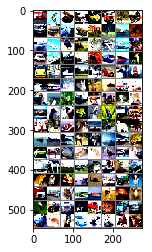

In [3]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    

    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)


# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [4]:
# Creates two non-overlapping subsets of CIFAR10 to train the shadow and target models. We assume the attacker 
# has access to data that is similar to but not the same as the data used to train the target.

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

target_train_idx = indices[:split2]
target_out_idx = indices[split2:]


target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)



# Initialize/Train Targets
The model being attacked; if network, architecture can differ from that of shadow network.

In [5]:
#Initialize NN
target_net_retrain_redacted = target_net_type_retrain_redacted().to(device)
target_net_retrain_redacted.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()

target_optim_retrain_redacted = optim.Adam(target_net_retrain_redacted.parameters(), lr=lr)

target_net_type_renormalized_redacted = target_net_type_renormalized_redacted().to(device)
target_net_type_renormalized_redacted.apply(models.weights_init)

target_optim_renormalized_redacted = optim.Adam(target_net_type_renormalized_redacted.parameters(), lr=lr)

In [6]:
for cn in range(1,10):
    train_entropic(target_net_retrain_redacted,
                   target_net_type_renormalized_redacted, 
                   target_train_loader, 
                   cifar10_testloader,
                   target_optim_retrain_redacted,
                   target_optim_renormalized_redacted,                   
                   target_loss, 
                   n_epochs,
                   classes=classes,
                   class_number=cn)

[24/25]
Training:
automobile redacted

bird Accuracy of 2450.0/2515.0 : 97.416 % average entropy 0.130
cat Accuracy of 2497.0/2522.0 : 99.009 % average entropy 0.088
deer Accuracy of 2412.0/2490.0 : 96.867 % average entropy 0.140
dog Accuracy of 2382.0/2411.0 : 98.797 % average entropy 0.090
frog Accuracy of 2472.0/2537.0 : 97.438 % average entropy 0.133
horse Accuracy of 2277.0/2530.0 : 90.000 % average entropy 0.235
ship Accuracy of 2495.0/2507.0 : 99.521 % average entropy 0.022
truck Accuracy of 2430.0/2479.0 : 98.023 % average entropy 0.051

 Accuracy = 97.70 %
Average Entropy (correct,wrong,total) = (0.075,0.690,0.089)


std (correct,wrong,total) = (0.176,0.284,0.201)

automobile redacted

bird Accuracy of 2375.0/2515.0 : 94.433 % average entropy 0.202
cat Accuracy of 2460.0/2522.0 : 97.542 % average entropy 0.127
deer Accuracy of 2417.0/2490.0 : 97.068 % average entropy 0.168
dog Accuracy of 2391.0/2411.0 : 99.170 % average entropy 0.059
frog Accuracy of 2518.0/2537.0 : 99.251 % 

automobile Accuracy of 839.0/1000.0 : 83.900 % average entropy 0.084
bird Accuracy of 694.0/1000.0 : 69.400 % average entropy 0.146
cat Accuracy of 603.0/1000.0 : 60.300 % average entropy 0.207
deer redacted

dog Accuracy of 625.0/1000.0 : 62.500 % average entropy 0.173
frog Accuracy of 800.0/1000.0 : 80.000 % average entropy 0.104
horse Accuracy of 817.0/1000.0 : 81.700 % average entropy 0.097
ship Accuracy of 891.0/1000.0 : 89.100 % average entropy 0.057
truck Accuracy of 806.0/1000.0 : 80.600 % average entropy 0.099

 Accuracy = 80.75 %
Average Entropy (correct,wrong,total) = (0.051,0.290,0.097)


std (correct,wrong,total) = (0.151,0.319,0.217)

automobile Accuracy of 832.0/1000.0 : 83.200 % average entropy 0.068
bird Accuracy of 648.0/1000.0 : 64.800 % average entropy 0.163
cat Accuracy of 573.0/1000.0 : 57.300 % average entropy 0.192
deer redacted

dog Accuracy of 607.0/1000.0 : 60.700 % average entropy 0.163
frog Accuracy of 827.0/1000.0 : 82.700 % average entropy 0.084
horse Acc

[24/25]
Training:
automobile Accuracy of 2518.0/2518.0 : 100.000 % average entropy 0.002
bird Accuracy of 2513.0/2515.0 : 99.920 % average entropy 0.004
cat Accuracy of 2517.0/2522.0 : 99.802 % average entropy 0.013
deer Accuracy of 2483.0/2490.0 : 99.719 % average entropy 0.010
dog Accuracy of 2410.0/2411.0 : 99.959 % average entropy 0.004
frog Accuracy of 2533.0/2537.0 : 99.842 % average entropy 0.007
horse Accuracy of 2530.0/2530.0 : 100.000 % average entropy 0.003
ship redacted

truck Accuracy of 2479.0/2479.0 : 100.000 % average entropy 0.001

 Accuracy = 99.92 %
Average Entropy (correct,wrong,total) = (0.004,0.574,0.004)


std (correct,wrong,total) = (0.034,0.220,0.038)

automobile Accuracy of 2518.0/2518.0 : 100.000 % average entropy 0.001
bird Accuracy of 2515.0/2515.0 : 100.000 % average entropy 0.003
cat Accuracy of 2522.0/2522.0 : 100.000 % average entropy 0.003
deer Accuracy of 2490.0/2490.0 : 100.000 % average entropy 0.002
dog Accuracy of 2411.0/2411.0 : 100.000 % average

In [2]:
f = open("/home/patrick/Documents/entropy.txt", "r")

In [3]:
fulltxt = f.read()

In [7]:
import pandas as pd
df = pd.DataFrame()
ft = fulltxt.split("\n")
category = None
algo = None
for line in ft:
    if len(line.split("Training")) > 1:
        category = 'Training'
        count = 0
        algo = 0
        print(line)
    if len(line.split("Test")) > 1:
        category = 'Test'
        count = 0
        algo = 0
        print(line)
    if len(line.split("entropy")) > 1:
        if count > 8:
            algo = 1
        sl = line.split()
        sl2 = line.split(' %')
        
        print(category, algo, sl[0],sl2[0].split()[-1], sl[-1])
        count = count + 1
        df = df.append( pd.DataFrame(data={"category": [category],
                                      "algo": [algo],
                                      "class": [sl[0]],
                                      "accuracy": [float(sl2[0].split()[-1])],
                                      "entropy": [float(sl[-1])]}), ignore_index=True)
        

Training:
Training 0 bird 97.416 0.130
Training 0 cat 99.009 0.088
Training 0 deer 96.867 0.140
Training 0 dog 98.797 0.090
Training 0 frog 97.438 0.133
Training 0 horse 90.000 0.235
Training 0 ship 99.521 0.022
Training 0 truck 98.023 0.051
Training 0 bird 94.433 0.202
Training 1 cat 97.542 0.127
Training 1 deer 97.068 0.168
Training 1 dog 99.170 0.059
Training 1 frog 99.251 0.057
Training 1 horse 94.743 0.156
Training 1 ship 96.929 0.128
Training 1 truck 99.758 0.023
Test:
Test 0 bird 60.900 0.330
Test 0 cat 59.200 0.340
Test 0 deer 63.100 0.350
Test 0 dog 64.900 0.293
Test 0 frog 72.100 0.254
Test 0 horse 61.700 0.282
Test 0 ship 92.000 0.074
Test 0 truck 85.300 0.118
Test 0 bird 54.400 0.343
Test 1 cat 53.900 0.357
Test 1 deer 63.000 0.374
Test 1 dog 67.200 0.270
Test 1 frog 80.500 0.200
Test 1 horse 67.400 0.261
Test 1 ship 75.600 0.208
Test 1 truck 88.300 0.098
Training:
Training 0 automobile 98.570 0.037
Training 0 cat 97.383 0.077
Training 0 deer 99.719 0.012
Training 0 dog 99.

In [9]:
df.head()

,category,algo,class,accuracy,entropy
0,Training,0,bird,97.416,0.130
1,Training,0,cat,99.009,0.088
2,Training,0,deer,96.867,0.140
3,Training,0,dog,98.797,0.090
4,Training,0,frog,97.438,0.133


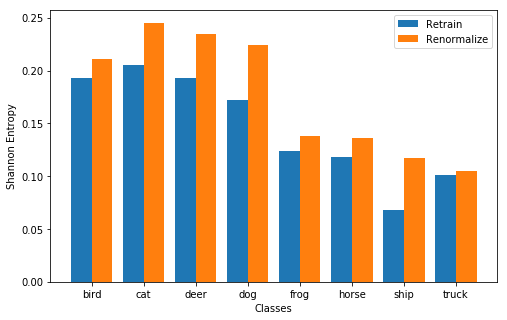

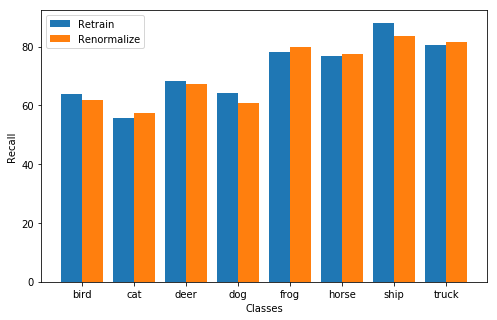

In [58]:
entr0 = [df[(df.algo == 0) & (df.category == 'Test') & (df['class'] == s)].entropy.mean() for s in shapes]
entr1 = [df[(df.algo == 1) & (df.category == 'Test') & (df['class'] == s)].entropy.mean() for s in shapes]

acc0 = [df[(df.algo == 0) & (df.category == 'Test') & (df['class'] == s)].accuracy.mean() for s in shapes]
acc1 = [df[(df.algo == 1) & (df.category == 'Test') & (df['class'] == s)].accuracy.mean() for s in shapes]


def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

plt.figure(figsize=(8,5))
subcategorybar(shapes,[entr0, entr1] )
plt.ylabel('Shannon Entropy')
plt.xlabel('Classes')
plt.legend(['Retrain','Renormalize'])

plt.savefig("entropy.png")
plt.show()

plt.figure(figsize=(8,5))
subcategorybar(shapes,[acc0, acc1] )
plt.ylabel('Recall')
plt.xlabel('Classes')
plt.legend(['Retrain','Renormalize'])
plt.savefig("recall.png")
plt.show()